In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
n_noise = 100
n_channel = 3
n_iter = 200
lr = 0.0002

gf = 64
df = 64

batch_size = 64
image_size = 64

In [3]:
transform = transforms.Compose([
    transforms.Scale(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='../../CIFAR10/',train=True, download=True, transform = transform)

C:\Users\my\Anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified


In [4]:
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

(32, 32, 3)

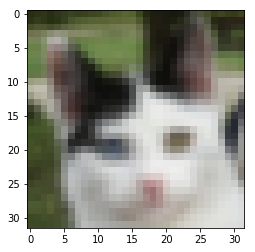

In [5]:
plt.imshow(train_data.train_data[6070])
train_data.train_data[6070].shape

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convT1 = nn.ConvTranspose2d(n_noise, gf * 16, 4, 1, 0, bias=False)
        self.BN1 = nn.BatchNorm2d(gf * 16)
        self.relu1 = nn.ReLU()
        
        self.convT2 = nn.ConvTranspose2d(gf * 16, gf * 8 , 4, 2, 1, bias=False)
        self.BN2 = nn.BatchNorm2d(gf * 8)
        self.relu2 = nn.ReLU()
        
        self.convT3 = nn.ConvTranspose2d(gf * 8, gf * 4, 4, 2, 1, bias=False)
        self.BN3 = nn.BatchNorm2d(gf * 4)
        self.relu3 = nn.ReLU()
        
        self.convT4 = nn.ConvTranspose2d(gf * 4, gf * 2, 4, 2, 1, bias=False)
        self.BN4 = nn.BatchNorm2d(gf * 2)
        self.relu4 = nn.ReLU()
        
        self.convT5 = nn.ConvTranspose2d(gf * 2, n_channel, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = self.relu1(self.BN1(self.convT1(x)))
        x = self.relu2(self.BN2(self.convT2(x)))
        x = self.relu3(self.BN3(self.convT3(x)))
        x = self.relu4(self.BN4(self.convT4(x)))
        x = self.convT5(x)
        
        return F.sigmoid(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(n_channel, df * 2, 4, 2, 1, bias=False)
        self.relu1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(df * 2, df * 4, 4, 2, 1, bias=False)
        self.BN2 = nn.BatchNorm2d(df * 4)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv2d(df * 4, df * 8, 4, 2, 1, bias=False)
        self.BN3 = nn.BatchNorm2d(df * 8)
        self.relu3 = nn.LeakyReLU()
        
        self.conv4 = nn.Conv2d(df * 8, df * 16, 4, 2, 1, bias=False)
        self.BN4 = nn.BatchNorm2d(df * 16)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv2d(df * 16, 1, 4, 1, 0, bias=False)
            
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.BN2(self.conv2(x)))
        x = self.relu3(self.BN3(self.conv3(x)))
        x = self.relu4(self.BN4(self.conv4(x)))
        x = self.conv5(x)
        
        return F.sigmoid(x).view(-1, 1).squeeze(1)

In [16]:
G = Generator()
D = Discriminator()
G = G.cuda()
D = D.cuda()
torch.backends.cudnn.benchmark=True


criterion = nn.BCELoss()

inputs = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, n_noise, 1, 1).cuda()
fixed_noise = torch.FloatTensor(batch_size, n_noise, 1, 1).normal_(0, 1)
fixed_noise = Variable(fixed_noise).cuda()

label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0


In [17]:
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)

In [30]:
for epoch in range(1):
    for i, data in enumerate(train_loader):
        D.zero_grad()
        
        real_data, _ = data
        batch_size = real_data.size(0)
        
        d_real_data = Variable(real_data).cuda()
        d_real_decision = D(d_real_data)
        d_real_error = criterion(d_real_decision, Variable(torch.ones(batch_size)).cuda())
        d_real_error.backward()
        
        d_gen_input = Variable(torch.rand(batch_size, n_noise).normal_(0, 1)).cuda()
        d_fake_data = G(d_gen_input).detach()
        d_fake_decision = D(d_fake_data)
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(batch_size)).cuda())
        d_fake_error.backward()
        optimizerD.step()
        
        
        
        
        
        G.zero_grad()
        
        gen_input = Variable(torch.rand(batch_size, n_noise).normal_(0, 1)).cuda()
        g_fake_data = G(gen_input)
        dg_fake_decision = D(g_fake_data)
        g_error = criterion(df_fake_decision, Variable(torch.ones(batch_size)).cuda())
        
        g_error.backward()
        optimizerG.step()
        
#         D.zero_grad()
#         real_cpu, _ = data
#         batch_size = real_cpu.size(0)
        
#         inputs.resize_as_(real_cpu).copy_(real_cpu)
#         label.resize_(batch_size).fill_(real_label)
        
#         inputv =  Variable(inputs).cuda()
#         labelv = Variable(label).cuda()
        
#         output = D(inputv)
#         errD_real = criterion(output, labelv)
#         errD_real.backward()
# #         D_x = output.data.mean()
        
#         noise.resize_(batch_size, n_noise, 1, 1).normal_(0,1)
#         noisev = Variable(noise).cuda()
#         labelv = Variable(label.fill_(fake_label)).cuda()
#         fake = G(noisev)
#         output = D(fake.detach())
#         errD_fake = criterion(output, labelv)
#         errD_fake.backward()
# #         D_G_z1 = output.data.mean()
        
# #         errD = errD_real + errD_fake
#         optimizerD.step()
    
#         G.zero_grad()
#         labelv = Variable(label.fill_(real_label)).cuda()
#         output = D(fake)
#         errG = criterion(output, labelv)
#         errG.backward()
#         optimizerG.step()
        
        if( (i+1) % 100 == 0):
            print(i, "step")
            fake = G(torch.rand(batch_size, n_noise).normal_(0, 1))
            vutils.save_image(fake.data, './%s/fake_samples_epoch_%s.png' % ('DCGAN_pytorch', str(epoch)+" "+str(i+1)), normalize=True)

    vutils.save_image(real_cpu, '%s/real_samples.png' % ('DCGAN_pytorch'), normalize=True)
    fake = netG(fixed_noise)
    vutils.save_image(fake.data,
            '%s/fake_samples_epoch_%s.png' % ('DCGAN_pytorch', epoch),
            normalize=True)
    
    # do checkpointing
    torch.save(G.state_dict(), '%s/netG.pth' % ('DCGAN_pytorch'))
    torch.save(D.state_dict(), '%s/netD.pth' % ('DCGAN_pytorch'))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [100, 1024, 4, 4], but got 2-dimensional input of size [64, 100] instead

In [24]:
torch.rand(10, 5).normal_(0, 1)
batch_size

16